In [ ]:
# Model training of text classiffiers using logreg, svm, mlp 
# Violeta Berdejo-Espinola, Akos Hajas, Nan Ye
# November 2024

# read data

In [2]:
import mpu

# x data
x_raw = mpu.io.read('../data/v2/corpus_raw.pickle')
x = mpu.io.read('../data/v2/corpus_clean.pickle')

# pos, negs
pos = mpu.io.read('../data/v2/pos.pickle')
neg = mpu.io.read('../data/v2/neg.pickle')

# y 

y = mpu.io.read('../data/v2/y.pickle')

In [7]:
x[:3], x_raw[:3], y[:20]

(['anatomía agalla ficus benjamín moraceae asociado thrips tubulifera phlaeothripidae agalla ser reconocer generalmente crecimiento anormal tejido afectado insecto realizar deposición huevecillo alimentar tejido plantar ficus benjamín acción thrips gynaikothrips garitacambroneroi alimentar tejido hoja provocar agalla consistir doblamiento hojo trabajo analizar ultraestructuro sección hoja sano hoja agalla benjamín mediante uso microscopio electrónico barrido analizar cantidad estoma área determinar alteración significativo aunque observar menor cantidad cero cuticular superficie área afectado agalla zona hojo afectado garitacambroneroi observar bacilo hongo huevecillo organismo aparentemente invasor además tejido interno hoja agalla poder determinar problema diferenciación mesófilo empalizado esponjoso observar sólo tejido parenquimático',
  'distribución geográfico scincella incerto squamata scincidae chiapas méxico resumir presentar nuevo registro sincella incerto chiapa confirmar pr

In [3]:
# calculate weights

weight_for_class_0 = len(x) / (len(neg) * 2) 
weight_for_class_1 = len(x) / (len(pos) * 2) 
weight_for_class_0 +weight_for_class_1 

63.5721774593006

# split data

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_raw, y, test_size=0.20, random_state=42, stratify=y)

In [29]:
len(x_test_r)

1110

In [10]:
from collections import Counter

counter = Counter()

for i in y_test_r:
    counter[i] +=1
    
print(counter)

Counter({0: 1101, 1: 9})


# instantiate feature extractors, embedding models, resamplers, models 

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer # uses one-dim array of strings ~ shape (n,)
from sklearn.feature_extraction.text import CountVectorizer # returns arrays

vect_cv = CountVectorizer()
vect_tfidf = TfidfVectorizer()

model_mpnet = 'paraphrase-multilingual-mpnet-base-v2'
model_distill = 'distiluse-base-multilingual-cased-v1'

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN 

rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
ros = RandomOverSampler(random_state=42, sampling_strategy='not majority')
ada = ADASYN(random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

logreg = LogisticRegression(solver='liblinear', random_state=42)
logreg_weight = LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=42, C=0.01)

svm = SVC(kernel='linear')
svm_weight = SVC(kernel='linear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, probability=True, C=0.01)

mlp = MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(), learning_rate='constant',learning_rate_init=0.001, solver='adam', random_state=42)
# mlp_t = MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(5,), learning_rate='invscaling',learning_rate_init=1, solver='sgd', random_state=42, max_iter=400)

# function to train eval models

In [6]:
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline 

from embetter.text import SentenceEncoder

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score, precision_score, recall_score

import pandas as pd

In [13]:
# TF TFIDF baseline and weighted

def train_eval_tf_tfidf(x_train, y_train, x_test, y_test, kfold):
    
    def run_estimator(estimator, feature_extractor, balanced):
        
        pipeline = Pipeline([("vectorizer", feature_extractor),
                             ("estimator", estimator)
                            ])
    
        y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') # cross val splits the data and then applies the pipeline steps

        pipeline.fit(x_train, y_train)
        
        y_train_pred = pipeline.predict(x_train)

        y_test_pred = pipeline.predict(x_test)

        return {
            'Classifier': pipeline['estimator'],
            'Feature_extraction': pipeline['vectorizer'],
            'Weighting': 'Weighted' if balanced else 'None',
            'CV': kfold,
            'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
            'F1_tr': round(f1_score(y_train, y_train_pred), 3),
            'F1_ts': round(f1_score(y_test, y_test_pred), 3),
            'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
            'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
            'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
            'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
            'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
            'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }


    all_scores = []
    
    for feature_extractor in [vect_cv, vect_tfidf]:
        
        for estimator in [logreg, svm]:
            all_scores.append(run_estimator(estimator, feature_extractor, False))
            
        for estimator in [logreg_weight, svm_weight]: 
            all_scores.append(run_estimator(estimator, feature_extractor, True))

    return all_scores

In [16]:
# embeddings baseline and weighted

def train_eval_embeddings(x_train, y_train, x_test, y_test, kfold):

    def run_estimator(estimator, balanced):
        
        pipeline = make_pipeline(
            SentenceEncoder(embedding_model),
            estimator
        )
        
        y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict')

        pipeline.fit(x_train, y_train)
        
        y_train_pred = pipeline.predict(x_train)

        y_test_pred = pipeline.predict(x_test)

        return {
            'Classifier': estimator,
            'Feature_extraction': embedding_model,
            'Weighting': 'Weighted' if balanced else None,
            'CV': kfold,
            'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
            'F1_tr': round(f1_score(y_train, y_train_pred), 3),
            'F1_ts': round(f1_score(y_test, y_test_pred), 3),
            'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
            'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
            'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
            'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
            'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
            'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }

    all_scores = []
    
    for embedding_model in [model_distill, model_mpnet]:
        
            for estimator in [logreg, svm, mlp]:
                all_scores.append(run_estimator(estimator, False))
                
            for estimator in [logreg_weight, svm_weight]: 
                all_scores.append(run_estimator(estimator, True))

    return all_scores

In [19]:
# TF TFIDF resampled

def train_eval_tf_tfidf_resampled(x_train, y_train, x_test, y_test, kfold):
    
    all_scores = []
    
    for feature_extractor in [vect_cv, vect_tfidf]:
        
        for resampler in [rus, ros, ada]:
        
            for estimator in [logreg, svm, mlp]:
        
                pipeline = Pipeline([("vectorizer", feature_extractor),
                                    ("resampler", resampler),
                                    ("estimator", estimator)
                                    ])
        
                y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict')

                pipeline.fit(x_train, y_train)
                
                y_train_pred = pipeline.predict(x_train)

                y_test_pred = pipeline.predict(x_test)

                scores = {
                    'Classifier': pipeline['estimator'],
                    'Feature_extraction': pipeline['vectorizer'],
                    'Weighting': pipeline['resampler'],
                    'CV': kfold,
                    'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
                    'F1_tr': round(f1_score(y_train, y_train_pred), 3),
                    'F1_ts': round(f1_score(y_test, y_test_pred), 3),
                    'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
                    'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
                    'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
                    'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
                    'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
                    'Recall_ts': round(recall_score(y_test, y_test_pred), 3)    
                }
    
                all_scores.append(scores)

    return all_scores

In [24]:
# embeddings resampled

def train_eval_embedding_resampled(x_train, y_train, x_test, y_test, kfold, embed_model):
    
    all_scores = []
    
    pipeline = make_pipeline(
        SentenceEncoder(embed_model),
        RandomOverSampler(random_state=42, sampling_strategy='not majority'),
        MLPClassifier(activation='logistic', batch_size=16, hidden_layer_sizes=(), learning_rate='constant',learning_rate_init=0.001, solver='adam', random_state=42)
    )
                                
    y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict')

    pipeline.fit(x_train, y_train)
    
    y_train_pred = pipeline.predict(x_train)

    y_test_pred = pipeline.predict(x_test)

    scores = {
        'Classifier': mlp,
        'Feature_extraction': embed_model,
        'Weighting': ros,
        'CV': kfold,
        'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
        'F1_tr': round(f1_score(y_train, y_train_pred), 3),
        'F1_ts': round(f1_score(y_test, y_test_pred), 3),
        'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
        'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
        'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
        'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
        'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
        'Recall_ts': round(recall_score(y_test, y_test_pred), 3)    
    }

    all_scores.append(scores)

    return all_scores

# train eval models

In [14]:
# TF TFIDF baseline and weighted

df1 = pd.DataFrame(train_eval_tf_tfidf(x_train, y_train, x_test, y_test,2))
df1.sort_values(by=['Recall_ts','F1_tr_cv'], ascending=[False, False]).reset_index(drop=True)

/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqv

,Classifier,Feature_extraction,Weighting,CV,F1_tr_cv,F1_tr,F1_ts,Precision_tr_cv,Precision_tr,Precision_ts,Recall_tr_cv,Recall_tr,Recall_ts
0,"LogisticRegression(C=0.01,\n ...",TfidfVectorizer(),Weighted,2,0.131,0.707,0.0,0.154,0.547,0.0,0.114,1.000,0.0
1,"LogisticRegression(C=0.01,\n ...",CountVectorizer(),Weighted,2,0.113,0.795,0.0,0.167,0.660,0.0,0.086,1.000,0.0
2,"SVC(C=0.01, class_weight={0: 0.503995641118779...",TfidfVectorizer(),Weighted,2,0.015,0.794,0.0,0.008,0.893,0.0,0.486,0.714,0.0
3,"LogisticRegression(random_state=42, solver='li...",CountVectorizer(),None,2,0.000,1.000,0.0,0.000,1.000,0.0,0.000,1.000,0.0
4,SVC(kernel='linear'),CountVectorizer(),None,2,0.000,1.000,0.0,0.000,1.000,0.0,0.000,1.000,0.0
5,"SVC(C=0.01, class_weight={0: 0.503995641118779...",CountVectorizer(),Weighted,2,0.000,0.946,0.0,0.000,0.897,0.0,0.000,1.000,0.0
6,"LogisticRegression(random_state=42, solver='li...",TfidfVectorizer(),None,2,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0
7,SVC(kernel='linear'),TfidfVectorizer(),None,2,0.000,0.293,0.0,0.000,1.000,0.0,0.000,0.171,0.0


In [17]:
# embeddings baseline and weighted

df2 = pd.DataFrame(train_eval_embeddings(x_train_r, y_train_r, x_test_r, y_test_r,2))
df2.sort_values(by=['Recall_ts','F1_tr_cv'], ascending=[False, False]).reset_index(drop=True)

/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqv

,Classifier,Feature_extraction,Weighting,CV,F1_tr_cv,F1_tr,F1_ts,Precision_tr_cv,Precision_tr,Precision_ts,Recall_tr_cv,Recall_tr,Recall_ts
0,"SVC(C=0.01, class_weight={0: 0.503995641118779...",paraphrase-multilingual-mpnet-base-v2,Weighted,2,0.068,0.075,0.071,0.035,0.039,0.037,0.829,1.000,1.000
1,"LogisticRegression(C=0.01,\n ...",paraphrase-multilingual-mpnet-base-v2,Weighted,2,0.075,0.084,0.071,0.039,0.044,0.037,0.743,0.971,0.889
2,"LogisticRegression(C=0.01,\n ...",distiluse-base-multilingual-cased-v1,Weighted,2,0.086,0.124,0.096,0.047,0.066,0.051,0.571,0.914,0.778
3,"SVC(C=0.01, class_weight={0: 0.503995641118779...",distiluse-base-multilingual-cased-v1,Weighted,2,0.051,0.113,0.089,0.027,0.060,0.047,0.571,0.914,0.778
4,"MLPClassifier(activation='logistic', batch_siz...",paraphrase-multilingual-mpnet-base-v2,None,2,0.042,0.500,0.000,0.077,0.923,0.000,0.029,0.343,0.000
5,"LogisticRegression(random_state=42, solver='li...",distiluse-base-multilingual-cased-v1,None,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,SVC(kernel='linear'),distiluse-base-multilingual-cased-v1,None,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,"MLPClassifier(activation='logistic', batch_siz...",distiluse-base-multilingual-cased-v1,None,2,0.000,0.364,0.000,0.000,0.889,0.000,0.000,0.229,0.000
8,"LogisticRegression(random_state=42, solver='li...",paraphrase-multilingual-mpnet-base-v2,None,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,SVC(kernel='linear'),paraphrase-multilingual-mpnet-base-v2,None,2,0.000,0.108,0.000,0.000,1.000,0.000,0.000,0.057,0.000


In [20]:
# TF TFIDF resampled

df3 = pd.DataFrame(train_eval_tf_tfidf_resampled(x_train, y_train, x_test, y_test,2))
df3.sort_values(by=['Recall_ts','F1_tr_cv'], ascending=[False, False]).reset_index(drop=True)

/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqv

,Classifier,Feature_extraction,Weighting,CV,F1_tr_cv,F1_tr,F1_ts,Precision_tr_cv,Precision_tr,Precision_ts,Recall_tr_cv,Recall_tr,Recall_ts
0,"MLPClassifier(activation='logistic', batch_siz...",TfidfVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.032,0.046,0.050,0.016,0.024,0.026,0.800,1.0,1.000
1,"MLPClassifier(activation='logistic', batch_siz...",CountVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.034,0.057,0.056,0.017,0.029,0.029,0.771,1.0,0.889
2,SVC(kernel='linear'),TfidfVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.053,0.109,0.074,0.028,0.057,0.039,0.686,1.0,0.667
3,"LogisticRegression(random_state=42, solver='li...",TfidfVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.052,0.101,0.058,0.027,0.053,0.031,0.743,1.0,0.556
4,"LogisticRegression(random_state=42, solver='li...",CountVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.033,0.064,0.040,0.017,0.033,0.021,0.657,1.0,0.556
5,SVC(kernel='linear'),CountVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.039,0.092,0.024,0.020,0.048,0.012,0.600,1.0,0.222
6,"LogisticRegression(random_state=42, solver='li...",TfidfVectorizer(),"RandomOverSampler(random_state=42, sampling_st...",2,0.100,0.909,0.000,0.400,0.833,0.000,0.057,1.0,0.000
7,"LogisticRegression(random_state=42, solver='li...",TfidfVectorizer(),ADASYN(random_state=42),2,0.098,0.909,0.000,0.333,0.833,0.000,0.057,1.0,0.000
8,"MLPClassifier(activation='logistic', batch_siz...",CountVectorizer(),ADASYN(random_state=42),2,0.054,0.986,0.000,0.500,0.972,0.000,0.029,1.0,0.000
9,SVC(kernel='linear'),CountVectorizer(),ADASYN(random_state=42),2,0.045,1.000,0.000,0.111,1.000,0.000,0.029,1.0,0.000


In [25]:
# embeddings resampled

df4 = pd.DataFrame(train_eval_embedding_resampled(x_train_r, y_train_r, x_test_r, y_test_r,2, model_mpnet))
df5 = pd.DataFrame(train_eval_embedding_resampled(x_train_r, y_train_r, x_test_r, y_test_r,2, model_distill))
df4.sort_values(by=['Recall_ts','F1_tr_cv'], ascending=[False, False]).reset_index(drop=True)
df5.sort_values(by=['Recall_ts','F1_tr_cv'], ascending=[False, False]).reset_index(drop=True)

,Classifier,Feature_extraction,Weighting,CV,F1_tr_cv,F1_tr,F1_ts,Precision_tr_cv,Precision_tr,Precision_ts,Recall_tr_cv,Recall_tr,Recall_ts
0,"MLPClassifier(activation='logistic', batch_siz...",distiluse-base-multilingual-cased-v1,"RandomOverSampler(random_state=42, sampling_st...",2,0.208,0.569,0.083,0.164,0.398,0.067,0.286,1.0,0.111


# cocatenate and save model results

In [26]:
res = pd.concat([df1,df2,df3,df4,df5])
res = res.sort_values(by=['Recall_ts','F1_tr_cv'], ascending=[False, False]).reset_index(drop=True)
res 

,Classifier,Feature_extraction,Weighting,CV,F1_tr_cv,F1_tr,F1_ts,Precision_tr_cv,Precision_tr,Precision_ts,Recall_tr_cv,Recall_tr,Recall_ts
0,"SVC(C=0.01, class_weight={0: 0.503995641118779...",paraphrase-multilingual-mpnet-base-v2,Weighted,2,0.068,0.075,0.071,0.035,0.039,0.037,0.829,1.000,1.000
1,"MLPClassifier(activation='logistic', batch_siz...",TfidfVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.032,0.046,0.050,0.016,0.024,0.026,0.800,1.000,1.000
2,"LogisticRegression(C=0.01,\n ...",paraphrase-multilingual-mpnet-base-v2,Weighted,2,0.075,0.084,0.071,0.039,0.044,0.037,0.743,0.971,0.889
3,"MLPClassifier(activation='logistic', batch_siz...",CountVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.034,0.057,0.056,0.017,0.029,0.029,0.771,1.000,0.889
4,"LogisticRegression(C=0.01,\n ...",distiluse-base-multilingual-cased-v1,Weighted,2,0.086,0.124,0.096,0.047,0.066,0.051,0.571,0.914,0.778
5,"SVC(C=0.01, class_weight={0: 0.503995641118779...",distiluse-base-multilingual-cased-v1,Weighted,2,0.051,0.113,0.089,0.027,0.060,0.047,0.571,0.914,0.778
6,SVC(kernel='linear'),TfidfVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.053,0.109,0.074,0.028,0.057,0.039,0.686,1.000,0.667
7,"LogisticRegression(random_state=42, solver='li...",TfidfVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.052,0.101,0.058,0.027,0.053,0.031,0.743,1.000,0.556
8,"LogisticRegression(random_state=42, solver='li...",CountVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.033,0.064,0.040,0.017,0.033,0.021,0.657,1.000,0.556
9,SVC(kernel='linear'),CountVectorizer(),"RandomUnderSampler(random_state=42, sampling_s...",2,0.039,0.092,0.024,0.020,0.048,0.012,0.600,1.000,0.222


In [27]:
# save model scores

res.to_csv('../results/v2/model_scores.csv')

In [10]:
from imblearn.pipeline import make_pipeline 

from embetter.text import SentenceEncoder

from sklearn.model_selection import cross_val_predict, StratifiedKFold

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

import numpy as np

# import statsmodels.api as sm

def train_eval_best_model(x_train, y_train, x_test, y_test, kfold, C):#solver, C, random_state):
    """"
    Train and test model
    
    Parameters:
    -----------
    x_train, x_test: list of strings
        raw text to create embeddings
    y_train_y_test: array 
        binary labels
    text_length: string 
        indicating whther it is 'text and asbtract' or 'text, asbtract, and main text'
    kfold: int
        indicating number of folds for cross validation
    embedding_model: string
        instantiation of embedding model
    random_state: int
        seed

        
    Returns:
    --------
    Dictionary with scores.
    Log losss values for test and train set.
    Array of test set predicitons
    """
    
    pipeline = make_pipeline(
        SentenceEncoder('paraphrase-multilingual-mpnet-base-v2'),
        # LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=42, C=C)
        SVC(kernel='linear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, probability=True, C=C)

    )

    y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') 

    pipeline.fit(x_train, y_train)
    
    model = pipeline.steps[-1][1]  # model object -svm logreg-

   # Ensure y_train is a NumPy array
    y_train = np.array(y_train)

    # Get predicted probabilities for training set
    probs = pipeline.predict_proba(x_train)
    probs = np.clip(probs, 1e-15, 1 - 1e-15)

    # Compute log-likelihood
    log_likelihood = np.sum(y_train * np.log(probs[:, 1]) + (1 - y_train) * np.log(probs[:, 0]))

    # Estimate number of parameters
    model = pipeline.steps[-1][1]
    k = model.support_vectors_.shape[1] + 1  # Approximate: num features + bias
    # k = model.coef_.size + model.intercept_.size  # Total number of parameters


    # Compute AIC
    aic = 2 * k - 2 * log_likelihood
    print(f"AIC: {aic}")
    
    y_train_pred = pipeline.predict(x_train)

    y_test_pred = pipeline.predict(x_test)

    scores = {
        'Classifier': 'Log_reg',
        'Feature_extraction': 'multilingual embedding model',
        'Weighting': 'Weighted',
        'CV': kfold,
        # 'Solver': solver,
        'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
        'F1_tr': round(f1_score(y_train, y_train_pred), 3),
        'F1_ts': round(f1_score(y_test, y_test_pred), 3),
        'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
        'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
        'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
        'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
        'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
        'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }
    
    # log loss train set
    y_pred_tr = pipeline.predict_proba(x_train) 
    logloss_tr = log_loss(y_train, y_pred_tr) 

    # log loss test set
    y_pred_ts = pipeline.predict_proba(x_test)  
    logloss_ts = log_loss(y_test, y_pred_ts)
    
    print(f'loss training set: {logloss_tr}, \nloss test set {logloss_ts}')
    print(f'confusion matrix train set:\n{confusion_matrix(y_train, pipeline.predict(x_train))}')
    print(f'confusion matrix test set:\n{confusion_matrix(y_test, pipeline.predict(x_test))}') 
    
     # Get predicted probabilities
    probs = pipeline.predict_proba(x_test_r)[:, 1]

    # Set a custom threshold
    threshold = 0.4  
    y_pred = (probs >= threshold).astype(int)

    # Evaluate results
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix at threshold =", threshold)
    print(cm)
 
    return scores,  y_pred_tr, y_pred_ts,  y_train_pred,  y_test_pred, logloss_tr, logloss_ts, cm, model, aic

# LOGREG

In [8]:
scores,  y_pred_tr, y_pred_ts,  y_train_pred,  y_test_pred, logloss_tr, logloss_ts, cm, model, aic = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 2, 0.01)

AIC: 5694.39978999575
loss training set: 0.46806303941393584, 
loss test set 0.46944036626911656
confusion matrix train set:
[[3667  738]
 [   1   34]]
confusion matrix test set:
[[893 208]
 [  1   8]]
Confusion Matrix at threshold = 0.4
[[679 422]
 [  0   9]]


In [11]:
scores

{'Classifier': 'Log_reg',
 'Feature_extraction': 'multilingual embedding model',
 'Weighting': 'Weighted',
 'CV': 2,
 'F1_tr_cv': 0.075,
 'F1_tr': 0.084,
 'F1_ts': 0.071,
 'Precision_tr_cv': 0.039,
 'Precision_tr': 0.044,
 'Precision_ts': 0.037,
 'Recall_tr_cv': 0.743,
 'Recall_tr': 0.971,
 'Recall_ts': 0.889}

# SVM

In [ ]:
scores_S,  y_pred_tr_S, y_pred_ts_S,  y_train_pred_S,  y_test_pred_S, logloss_tr_S, logloss_ts_S, cm_S, model_S, ai_Sc = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 2, 0.01)

In [56]:
scores, y_pred_ts, logloss_tr, logloss_ts, cm, model, aic = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 2, 0.01)


AIC: 1790.3955939108916
loss training set: 0.028422927242217507, 
loss test set 0.03696397865541656
confusion matrix train set:
[[3538  867]
 [   0   35]]
confusion matrix test set:
[[867 234]
 [  0   9]]
Confusion Matrix at threshold = 0.4
[[1101    0]
 [   9    0]]


In [82]:
y_pred_ts

array([[9.74493010e-01, 2.55069904e-02],
       [9.82615050e-01, 1.73849500e-02],
       [9.99782869e-01, 2.17131012e-04],
       ...,
       [9.98011028e-01, 1.98897241e-03],
       [9.91999951e-01, 8.00004905e-03],
       [9.93634579e-01, 6.36542065e-03]])

In [73]:
y_pred_ts_p = y_pred_ts[:,1] # subset class of interest --> 1d array
y_pred_ts_n = y_pred_ts[:,0]

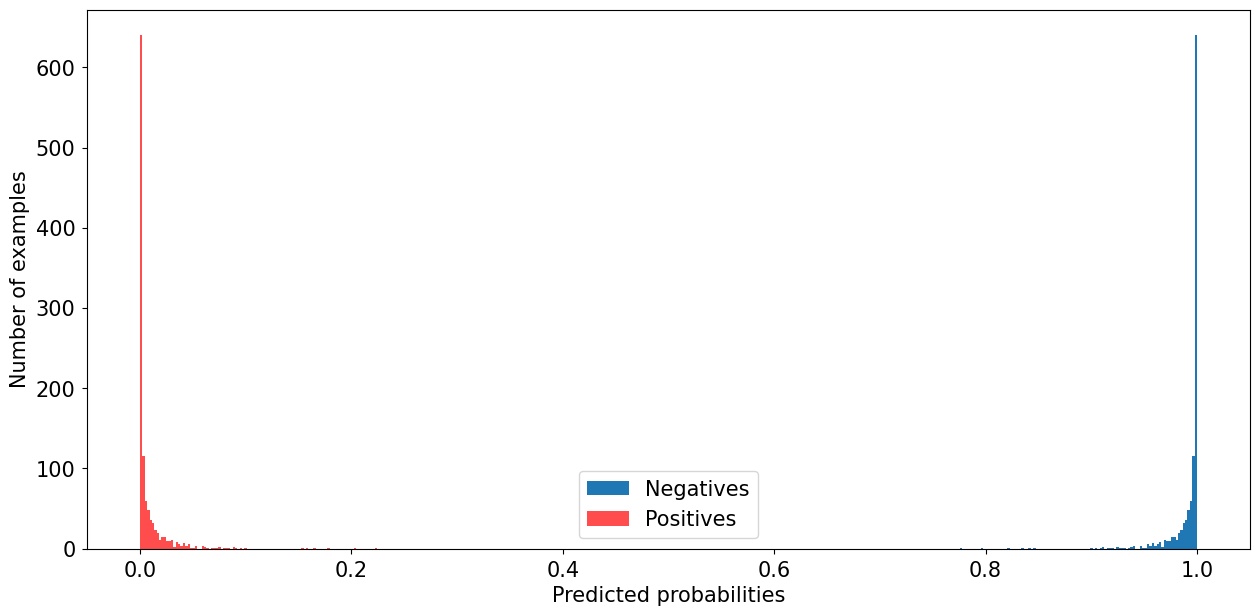

In [77]:
import matplotlib.pyplot as plt

y_pred_ts_p = y_pred_ts[:,1] # subset class of interest --> 1d array
y_pred_ts_n = y_pred_ts[:,0]

plt.figure(figsize=(15,7))
plt.hist(y_pred_ts_n, bins=100, label='Negatives')
plt.hist(y_pred_ts_p, bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Predicted probabilities', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.savefig('../results/v2/predicted_proba_svm_ts.png', dpi=300, bbox_inches='tight')
plt.show() 

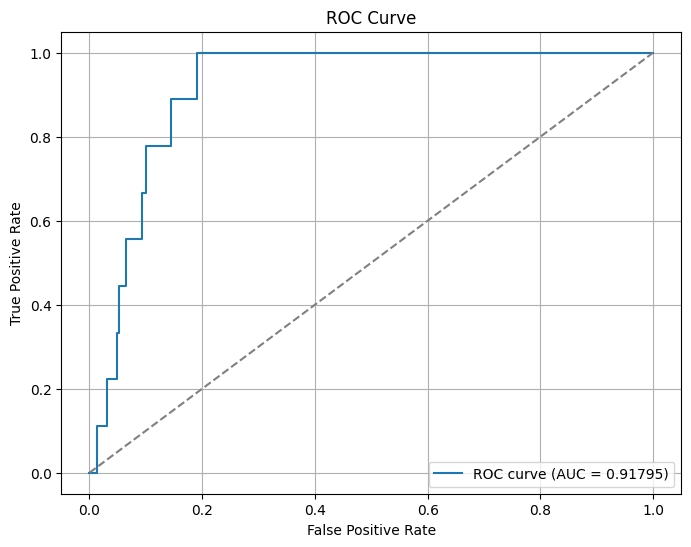

In [78]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# True labels and predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ts_p)
auc_score = roc_auc_score(y_test, y_pred_ts_p)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.5f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig('../results/v2/roc_curve_svm.png', dpi=300, bbox_inches='tight')
plt.show()

# LOG REG

In [67]:
scores1, y_pred_ts1, logloss_tr1, logloss_ts1, cm1, model1, aic1 = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 2, 0.01)


AIC: 5694.39978999575
loss training set: 0.46806303941393584, 
loss test set 0.46944036626911656
confusion matrix train set:
[[3667  738]
 [   1   34]]
confusion matrix test set:
[[893 208]
 [  1   8]]
Confusion Matrix at threshold = 0.4
[[679 422]
 [  0   9]]


In [70]:
pd.DataFrame({
    "model": [model, model1],
    "aic": [aic, aic1],
    
})

,model,aic
0,"SVC(C=0.01, class_weight={0: 0.503995641118779...",1790.395594
1,"LogisticRegression(C=0.01,\n ...",5694.399790


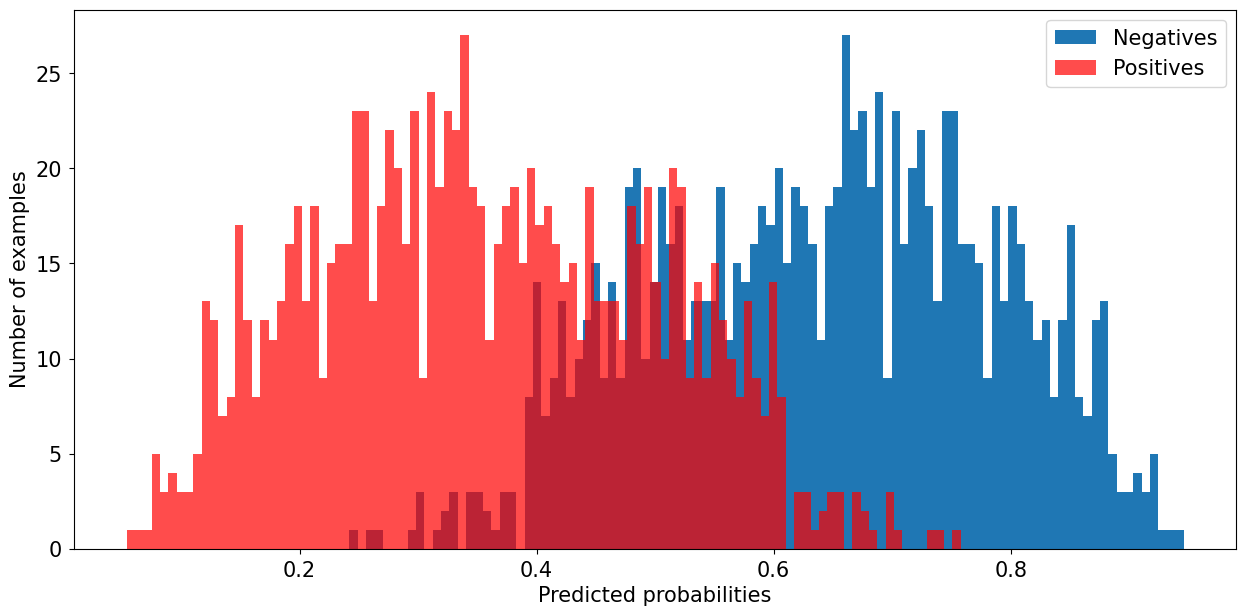

In [80]:
import matplotlib.pyplot as plt

y_pred_ts_p = y_pred_ts1[:,1] # subset class of interest --> 1d array
y_pred_ts_n = y_pred_ts1[:,0]

plt.figure(figsize=(15,7))
plt.hist(y_pred_ts_n, bins=100, label='Negatives')
plt.hist(y_pred_ts_p, bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Predicted probabilities', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.savefig('../results/v2/predicted_proba_logreg_ts.png', dpi=300, bbox_inches='tight')
plt.show() 

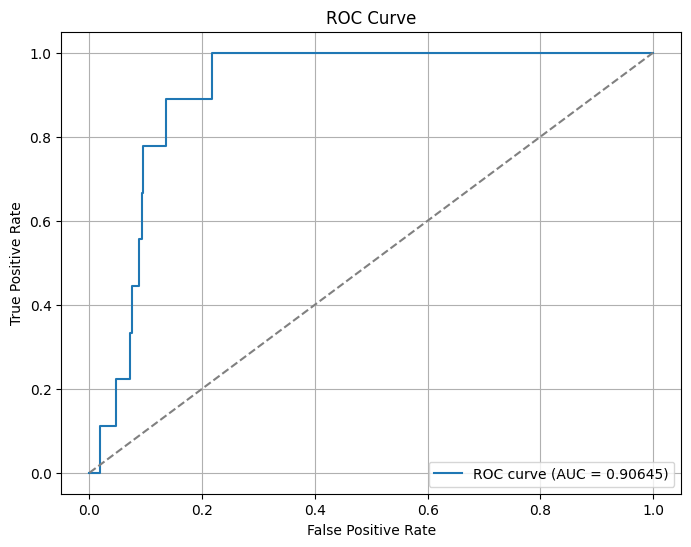

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# True labels and predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ts_p)
auc_score = roc_auc_score(y_test, y_pred_ts_p)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.5f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig('../results/v2/roc_curve_logreg.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 2, 'liblinear', 0.01, 24)
scores 

loss training set: 0.46806303941393584, 
loss test set 0.46944036626911656
confusion matrix train set:
[[3667  738]
 [   1   34]]
confusion matrix test set:
[[893 208]
 [  1   8]]
Confusion Matrix at threshold = 0.4
[[679 422]
 [  0   9]]


{'Classifier': 'Log_reg',
 'Feature_extraction': 'multilingual embedding model',
 'Weighting': 'Weighted',
 'CV': 2,
 'Solver': 'liblinear',
 'F1_tr_cv': 0.075,
 'F1_tr': 0.084,
 'F1_ts': 0.071,
 'Precision_tr_cv': 0.039,
 'Precision_tr': 0.044,
 'Precision_ts': 0.037,
 'Recall_tr_cv': 0.743,
 'Recall_tr': 0.971,
 'Recall_ts': 0.889}

In [ ]:
from imblearn.pipeline import make_pipeline 

from embetter.text import SentenceEncoder

from sklearn.svm import SVC

from sklearn.model_selection import cross_val_predict, StratifiedKFold

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

import numpy as np

# import statsmodels.api as sm

def train_eval_best_model(x_train, y_train, x_test, y_test, kfold, C):#solver, C, random_state):
    """"
    Train and test model
    
    Parameters:
    -----------
    x_train, x_test: list of strings
        raw text to create embeddings
    y_train_y_test: array 
        binary labels
    text_length: string 
        indicating whther it is 'text and asbtract' or 'text, asbtract, and main text'
    kfold: int
        indicating number of folds for cross validation
    embedding_model: string
        instantiation of embedding model
    random_state: int
        seed

        
    Returns:
    --------
    Dictionary with scores.
    Log losss values for test and train set.
    Array of test set predicitons
    """
    
    pipeline = make_pipeline(
        SentenceEncoder('paraphrase-multilingual-mpnet-base-v2'),
        # LogisticRegression(solver='liblinear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, random_state=42, C=C)
        SVC(kernel='linear', class_weight={0: weight_for_class_0, 1: weight_for_class_1}, probability=True, C=C)

    )

    y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') 

    pipeline.fit(x_train, y_train)
    
    y_train_pred = pipeline.predict(x_train)

    y_test_pred = pipeline.predict(x_test)
    
    # model object -svm logreg-
    model = pipeline.steps[-1][1]  
    
    # log loss train set
    y_train_pred_proba = pipeline.predict_proba(x_train) 
    logloss_tr = log_loss(y_train, y_train_pred_proba) 

    # log loss test set
    y_test_pred_proba = pipeline.predict_proba(x_test)  
    logloss_ts = log_loss(y_test, y_test_pred_proba)
    
    # compute AIC
    y_train = np.array(y_train)
    probs = np.clip(y_train_pred, 1e-15, 1 - 1e-15)
    log_likelihood = np.sum(y_train * np.log(y_train_pred_proba[:, 1]) + (1 - y_train) * np.log(y_train_pred_proba[:, 0])) # Compute log-likelihood
    model = pipeline.steps[-1][1] # estimate number of parameters
    k = model.support_vectors_.shape[1] + 1  # Approximate: num features + bias --> svm
    # k = model.coef_.size + model.intercept_.size  # Total number of parameters --> logreg
    # finally... compute AIC
    aic = 2 * k - 2 * log_likelihood
    print(f"AIC: {aic}")
    
    # get model scores 
    scores = {
        'CV': kfold,
        'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
        'F1_tr': round(f1_score(y_train, y_train_pred), 3),
        'F1_ts': round(f1_score(y_test, y_test_pred), 3),
        'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
        'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
        'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
        'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
        'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
        'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }
    
    
    
    print(f'loss training set: {logloss_tr}, \nloss test set {logloss_ts}')
    print(f'confusion matrix train set:\n{confusion_matrix(y_train, pipeline.predict(x_train))}')
    print(f'confusion matrix test set:\n{confusion_matrix(y_test, pipeline.predict(x_test))}') 
    
     # Get predicted probabilities
    predict_prob_positive = pipeline.predict_proba(x_test)[:,1]

    # Set a custom threshold
    threshold = 0.4  
    y_pred = (predict_prob_positive >= threshold).astype(int)

    # Evaluate results
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix at threshold =", threshold)
    print(cm)
 
    return scores, y_train_pred, y_test_pred, y_train_pred_proba, y_test_pred_proba, logloss_tr, logloss_ts, cm, model, aic

In [19]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 2, 'lbfgs') #logreg mpnet c=0.01

loss training set: 0.5667923568086795, 
loss test set 0.5674623700067758
confusion matrix train set:
[[3994  411]
 [   3   32]]
confusion matrix test set:
[[983 118]
 [  3   6]]


In [28]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 2, 'liblinear') #logreg mpnet c=0.001

loss training set: 0.6455102365052701, 
loss test set 0.6463010787408893
confusion matrix train set:
[[3279 1126]
 [   1   34]]
confusion matrix test set:
[[800 301]
 [  0   9]]
Confusion Matrix at threshold = 0.4
[[  16 1085]
 [   0    9]]


In [29]:
scores

{'Classifier': 'Log_reg',
 'Feature_extraction': 'multilingual embedding model',
 'Weighting': 'Weighted',
 'CV': 2,
 'Solver': 'liblinear',
 'F1_tr_cv': 0.052,
 'F1_tr': 0.057,
 'F1_ts': 0.056,
 'Precision_tr_cv': 0.027,
 'Precision_tr': 0.029,
 'Precision_ts': 0.029,
 'Recall_tr_cv': 0.829,
 'Recall_tr': 0.971,
 'Recall_ts': 1.0}

In [ ]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train_r, y_train_r, x_test_r, y_test_r, 2, 'liblinear') #logreg mpnet c=0.01

loss training set: 0.46806303941393584, 
loss test set 0.46944036626911656
confusion matrix train set:
[[3667  738]
 [   1   34]]
confusion matrix test set:
[[893 208]
 [  1   8]]
Confusion Matrix at threshold = 0.4
[[679 422]
 [  0   9]]


In [32]:
scores

{'Classifier': 'Log_reg',
 'Feature_extraction': 'multilingual embedding model',
 'Weighting': 'Weighted',
 'CV': 2,
 'Solver': 'liblinear',
 'F1_tr_cv': 0.075,
 'F1_tr': 0.084,
 'F1_ts': 0.071,
 'Precision_tr_cv': 0.039,
 'Precision_tr': 0.044,
 'Precision_ts': 0.037,
 'Recall_tr_cv': 0.743,
 'Recall_tr': 0.971,
 'Recall_ts': 0.889}